# Module 7 - Simple Harmonic Oscillators

<img src="http://i.imgur.com/l2WMuTN.gif">

## Goals

- Numerically solve the simple harmonic pendulum
- Euler-Cromer and Verlet methods

## Equation of Motion

The equation of motion for a simple linear pendulum of length $\ell$ and mass $m$ is given by:

$$ m \frac{d \vec{v}}{d t} = \vec{F}_{\rm g} = -m g \hat{y}$$

Measuring $x$ and $y$ from the equlibrium position we have 
\begin{align}
x &= \ell \sin \theta \\
y &= \ell (1-\cos\theta)
\end{align}

The kinetic and potential energy are:

\begin{align}
T &= \frac{1}{2} m \dot{r}^2 \\
&= \frac{1}{2} m (\dot{x}^2 + \dot{y}^2) \\
&= \frac{1}{2} m \ell^2 \dot{\theta}^2
\end{align}

\begin{equation}
V = m g \ell (1-\cos\theta).
\end{equation}

Thus, the Lagrangian is:
\begin{align}
\mathcal{L} &= T - V \\
&= \frac{1}{2} m \ell^2 \dot{\theta}^2 - m g \ell (1-\cos\theta) 
\end{align}
and the equation of motion is given by the Euler-Lagrange formula

\begin{align}
\frac{\partial \mathcal{L}}{\partial \theta} - \frac{d}{dt} \frac{\partial \mathcal{L}}{\partial \dot{\theta}} &= 0 \\
-m g \ell \sin \theta - \frac{d}{dt} (m\ell^2 \dot{\theta}) &= 0
\end{align}

which yields the familiar equation:
\begin{equation}
\ddot{\theta} = -\frac{g}{\ell} \sin\theta .
\end{equation}

In the small angle approximation, $\sin \theta \approx \theta$ for $\theta \ll 1$, we can simplify the differential equation as 

\begin{equation}
\ddot{\theta} = -\frac{g}{\ell} \theta ,
\end{equation}

which can be it can be integrated to give

$$ \theta(t) = \theta_0 \cos \left( \sqrt{\frac{g}{\ell}} t \right).$$

For $\theta(0) = \theta_0 \ll 1$ and $\dot{\theta}(0) = 0$ .


<div class="span alert alert-success">
<h2> Programming challenge </h2>
Use the Euler method to directly integrate the small angle approximation to the equation of motion and compare with the analytical expression for $\theta_0 = \pi/12$ and $\dot{\theta}(0) =0$ for $\ell = 0.25$ m. 

\begin{align}
\theta_{n+1} &= \theta_n + \omega_n \Delta t \\
\omega_{n+1} &= \omega_n - \frac{g}{\ell} \theta_n \Delta t \\
\end{align}
</div>

<!--
    θ[n+1] = θ[n] + ω[n]*Δt
    ω[n+1] = ω[n] -(g/ℓ)*np.sin(θ[n])*Δt
-->

In [1]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
#plt.style.use('notebook');
%config InlineBackend.figure_format = 'retina'
from scipy.constants import pi
from scipy.constants import g

# constants and intitial conditions
l = 0.25 # m
dt = 0.01 # s

t = np.arange(0.0,10.0,dt)
theta = np.zeros_like(t)
omega = np.zeros_like(t)
theta[0] = pi/12.0 # rad

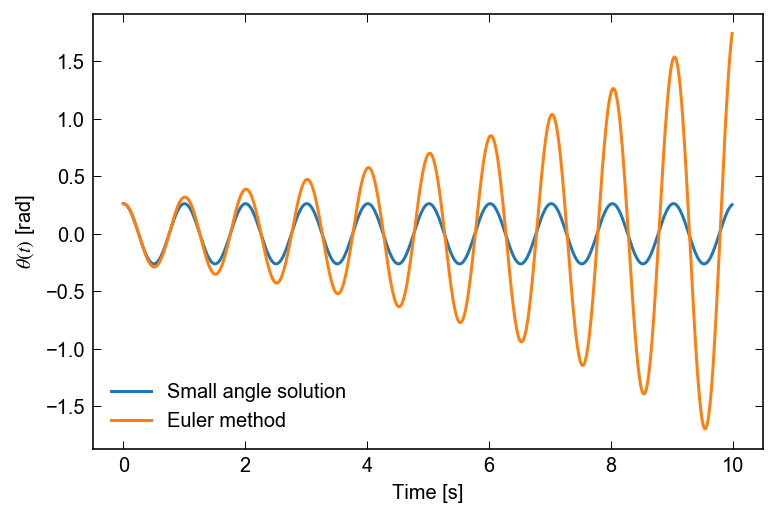

In [2]:
for n in range(t.size-1):
    theta[n+1] = theta[n] + omega[n]*dt
    omega[n+1] = omega[n] -(g/l)*theta[n]*dt
    
plt.figure()
# the small angle solution
plt.plot(t, theta[0]*np.cos(np.sqrt(g/l)*t), label='Small angle solution')

# the Euler method
plt.plot(t, theta, label='Euler method')
plt.legend(loc='lower left')

plt.xlabel('Time [s]')
plt.ylabel(r'$\theta(t)$ [rad]')

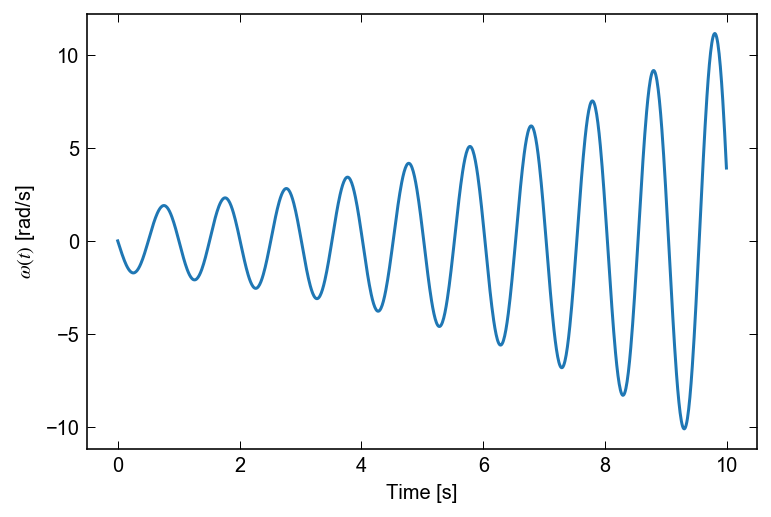

In [3]:
plt.figure()
plt.plot(t, omega, label='Small angle solution')
plt.xlabel('Time [s]')
plt.ylabel(r'$\omega(t)$ [rad/s]')

## What went wrong?

The oscillations are **growing** with time!  This is our first encounter with a numerical procedure that is **unstable**.  

Let's examine the total energy of the system where we can approximate $\cos\theta \simeq 1 - \theta^2/2$:

\begin{align}
E &= \frac{1}{2} m \ell^2 \omega^2 + m g \ell (1-\cos\theta) \\
&\simeq \frac{1}{2}m \ell^2 \left(\omega^2 + \frac{g}{\ell}\theta^2 \right).
\end{align}

Writing things in terms of our Euler variables:

\begin{align}
E_{n+1} &= \frac{1}{2}m\ell^2 \left[\left(\omega_n - \frac{g}{\ell}\theta_n \Delta t\right)^2 + \frac{g}{\ell}\left(\theta_n + \omega_n\Delta t\right)^2 \right] \\
&= E_{n} + \frac{1}{2}mg \ell \left(\omega_n^2 + \frac{g}{\ell} \theta_n^2\right) \Delta t^2.
\end{align}

This tells us the origin of the problem: **the energy is increasing without bound, regardless of the size of $\Delta t$**.

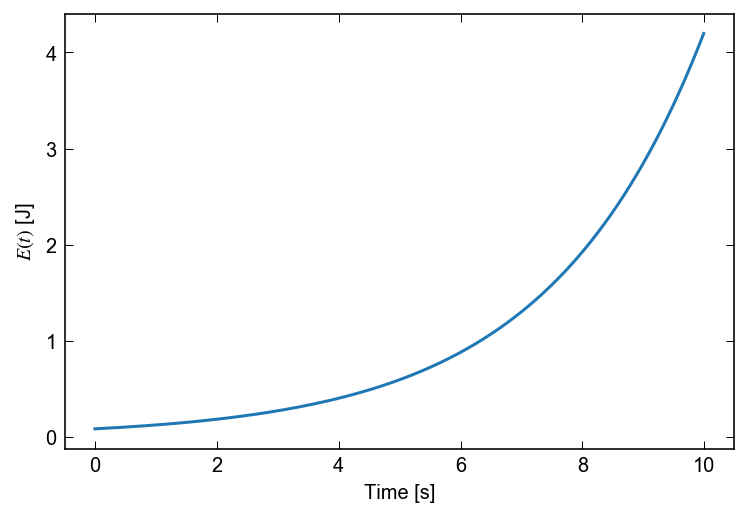

In [4]:
def energy(theta, omega, l):
    return 0.5*l**2*(omega**2 + g*theta**2/l)

plt.figure()
plt.plot(t, energy(theta, omega, l), label='Small angle solution')
plt.xlabel('Time [s]')
plt.ylabel(r'$E(t)$ [J]')

## A simple fix - Euler-Cromer method
Looking at our original discretized equations:

\begin{align}
\theta_{n+1} &= \theta_n + \omega_n \Delta t \\
\omega_{n+1} &= \omega_n - \frac{g}{\ell} \theta_n \Delta t
\end{align}

we can make the simple observation that we can replace the order of evaluation and use the updated value of $\omega$ in our calculation of $\theta$.

\begin{align}
\omega_{n+1} &= \omega_n - \frac{g}{\ell} \theta_n \Delta t \\
\theta_{n+1} &= \theta_n + \omega_{n+1} \Delta t
\end{align}

This leads to the energy being *approximately* conserved at each step:

\begin{equation}
E_{n+1} = E_{n} + \frac{1}{2}m g \left(\omega_n^2 - \frac{g}{\ell}\theta_n^2 \right)\Delta t^2 + \mathrm{O}(\Delta t^3).
\end{equation}


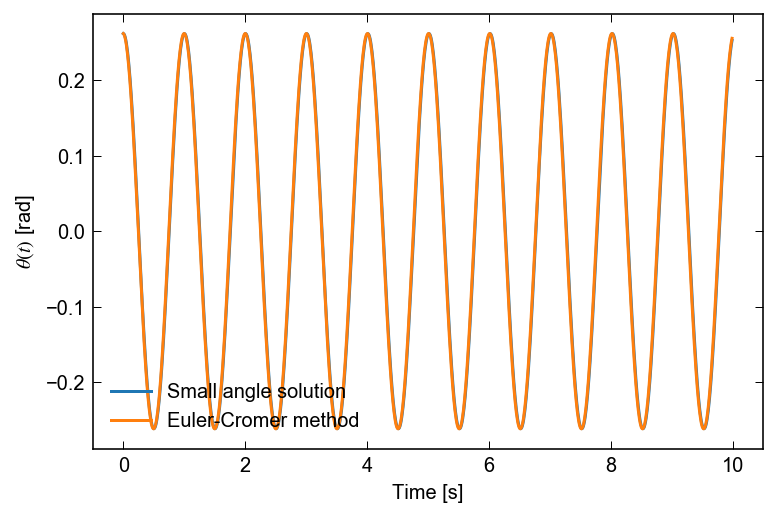

In [5]:
# constants and intitial conditions
l = 0.25 # m
dt = 0.01 # s

t = np.arange(0.0,10.0,dt)
theta = np.zeros_like(t)
omega = np.zeros_like(t)
theta[0] = pi/12.0 # rad

for n in range(t.size-1):
    omega[n+1] = omega[n] -(g/l)*theta[n]*dt
    theta[n+1] = theta[n] + omega[n+1]*dt

plt.figure()
# the small angle solution
plt.plot(t, theta[0]*np.cos(np.sqrt(g/l)*t), label='Small angle solution')

# the Euler method
plt.plot(t, theta, label='Euler-Cromer method')
plt.legend(loc='lower left')

plt.xlabel('Time [s]')
plt.ylabel(r'$\theta(t)$ [rad]')

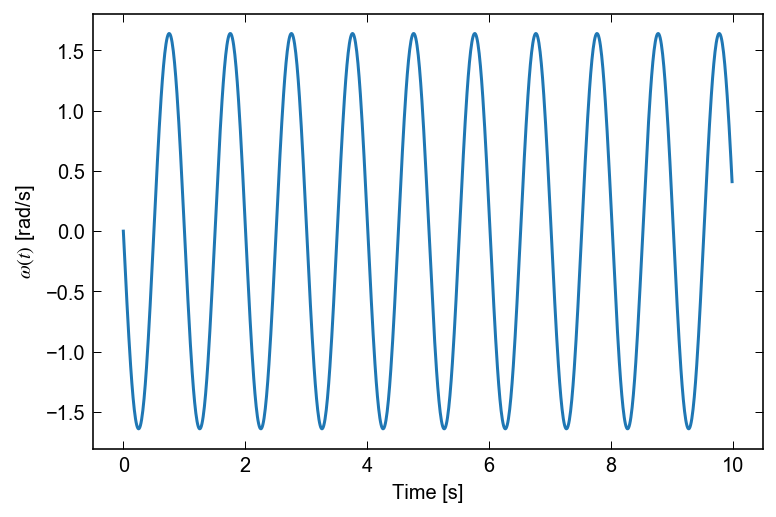

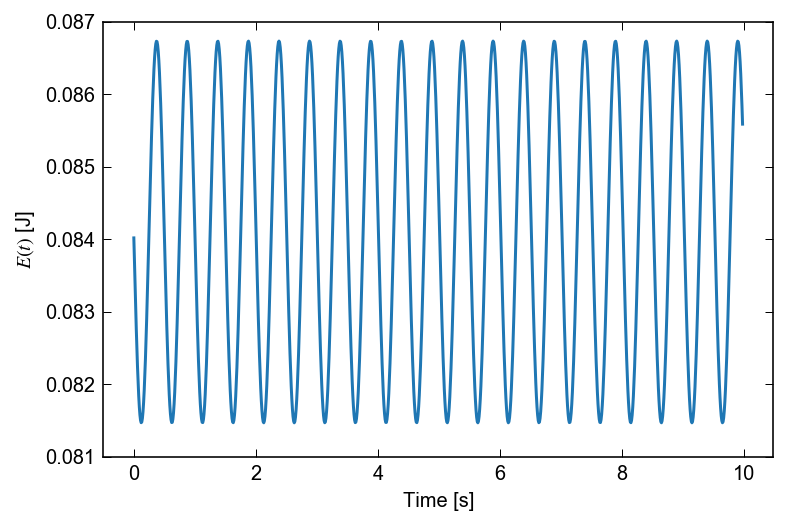

In [6]:
plt.figure()
plt.plot(t, omega, label='Small angle solution')
plt.xlabel('Time [s]')
plt.ylabel(r'$\omega(t)$ [rad/s]')
plt.figure()
plt.plot(t[:-1], energy(theta[:-1], omega[:-1], l), label='Small angle solution')
plt.xlabel('Time [s]')
plt.ylabel(r'$E(t)$ [J]')
plt.ylim(0.081,0.087)
EC_energy = energy(theta[:-1], omega[:-1], l)

The energy of the pendulum now oscillates around a constant value.

## An alternative fix - the Verlet method
So far, we have solved simple second order differential equations of the form

\begin{equation}
    \frac{d^2 y}{dt^2} = f_2(y,t)
\end{equation}

by converting them into two first order equations

\begin{align}
    \frac{dy}{dt} &= v \\
    \frac{dv}{dt} &= f_2(y,t).
\end{align}

However, we can use other methods to directly solve the second order differential equation. One such method is known as Verlet (first described in application to molecular dynamics). In the Verlet method we start by combining two Taylor expansions of our function (forward and backwards in time)

\begin{align}
    y(t + \Delta t) &= y(t) + \frac{dy}{dt}\Delta t + \frac{1}{2}\frac{d^2y}{dt^2}(\Delta t)^2 + \frac{1}{6}\frac{d^3y}{dt^3}(\Delta t)^3 + \dots \\
    y(t - \Delta t) &= y(t) - \frac{dy}{dt}\Delta t + \frac{1}{2}\frac{d^2y}{dt^2}(\Delta t)^2 - \frac{1}{6}\frac{d^3y}{dt^3}(\Delta t)^3 + \dots
\end{align}

By combining theses two expansions, we can cancel out the first and third order terms to obtain an expression for $y(t + \Delta t)$ based on the values of two previous time steps

\begin{equation}
    y(t + \Delta t) = 2y(t) - y(t - \Delta t) + \frac{d^2y}{dt^2}(\Delta t)^2 + O([\Delta t]^4)
\end{equation}

or in discrete form

\begin{equation}
    y_{i+1} = 2y_i - y_{i-1} + f_2(y_i,t_i)(\Delta t)^2 + O([\Delta t]^4).
\end{equation}

Notice that the error in this method is of order $(\Delta t)^4$. While this method does not directly return the first derivative of our function (i.e., $v = dy/dt$), one can readily use the central difference to calculate this quantity

\begin{equation}
    v_{i} = (y_{i+1} - y_{i-1})/(2\Delta t) + O([\Delta t]^2).
\end{equation}

One minor problem with the Verlet method is that it is not self-starting because we need two previous time points to calculate the current value. We can overcome this by computing the values for the first iteration using the Euler-Cromer method

\begin{align}
     v_1 &= v_0 + f_2(y_0, t_0) \Delta t \\
     y_1 &= y_0 + v_1 \Delta t.
\end{align}


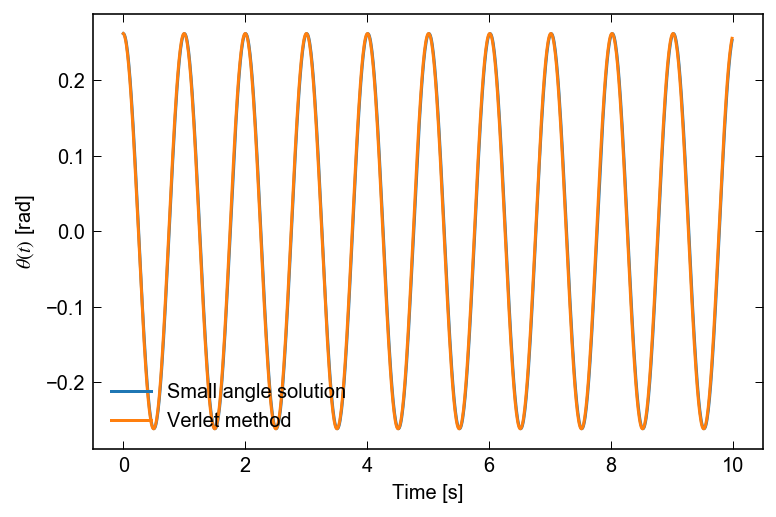

In [7]:
# constants and intitial conditions
l = 0.25 # m
dt = 0.01 # s

t = np.arange(0.0,10.0,dt)
theta = np.zeros_like(t)
omega = np.zeros_like(t)
theta[0] = pi/12.0 # rad

# Use Euler-Cromer method to find the solution for the first time step
omega[1] = omega[0] -(g/l)*theta[0]*dt
theta[1] = theta[0] + omega[1]*dt

# Use Verlet method to solve our equations from step 2 on
for n in range(1,t.size-1):
    theta[n+1] = 2*theta[n] - theta[n-1] - (g/l)*theta[n]*dt**2
    omega[n] = (theta[n+1] - theta[n-1])/(2.0*dt)

plt.figure()
# the small angle solution
plt.plot(t, theta[0]*np.cos(np.sqrt(g/l)*t), label='Small angle solution')

# the Euler method
plt.plot(t, theta, label='Verlet method')
plt.legend(loc='lower left')

plt.xlabel('Time [s]')
plt.ylabel(r'$\theta(t)$ [rad]')

(0.081, 0.087)

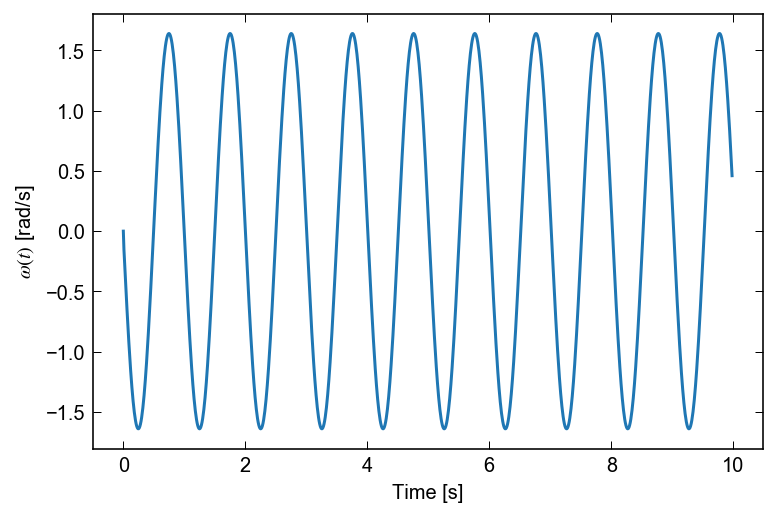

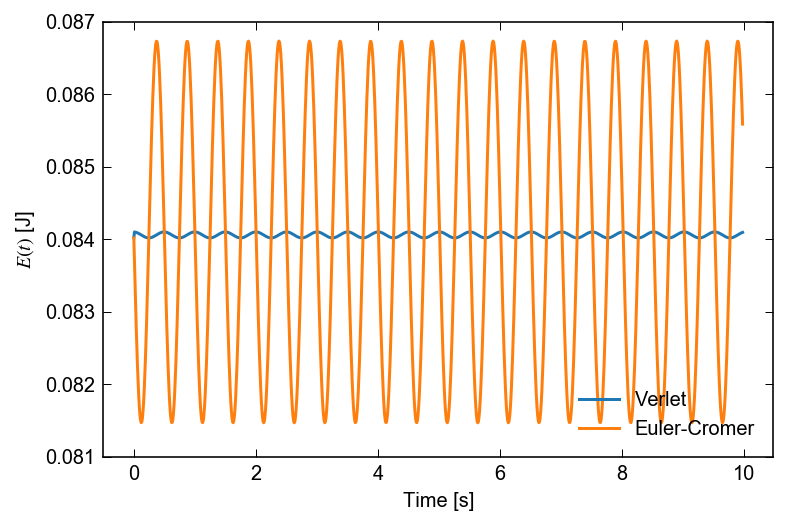

In [8]:
plt.figure()
plt.plot(t[:-1], omega[:-1], label='Small angle solution')
plt.xlabel('Time [s]')
plt.ylabel(r'$\omega(t)$ [rad/s]')
plt.figure()
plt.plot(t[:-1], energy(theta[:-1], omega[:-1], l), label='Verlet')
plt.plot(t[:-1], EC_energy, label='Euler-Cromer')
plt.legend()
plt.xlabel('Time [s]')
plt.ylabel(r'$E(t)$ [J]')
plt.ylim(0.081,0.087)

Energy is much better conserved when using the Verlet algorithm vs. Euler-Cromer for the same $\Delta t$.